In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence, pad_packed_sequence

In [2]:
def collate_fn(batch):
    inputs, genders, targets = zip(*batch)
    lengths = torch.tensor([len(input) for input in inputs])
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    genders = torch.tensor(genders)
    return inputs_padded, genders, targets_padded, lengths
class NamesDataset(Dataset):
    def __init__(self, names_list):
       
        self.names = ['.'+name[0]+'.' for name in names_list]
        #self.names = [type(name[0]) for name in names]
        self.genders = [name[1] for name in names_list]
        self.characters = sorted(list(set(''.join(self.names)))) 
        self.char_to_idx = {char: idx for idx, char in enumerate(self.characters,1)}
        self.idx_to_char = {idx: char for idx, char in enumerate(self.characters,1)}
        self.char_to_idx['0']=0
        self.idx_to_char[0]='0'
        print(self.char_to_idx,self.idx_to_char)
        

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        gender = self.genders[idx]
        input_seq = [self.char_to_idx[char] for char in name]
        input_tensor = input_seq[:-1]
        target_tensor = input_seq[1:]
        return torch.tensor(input_tensor, dtype=torch.long),torch.tensor(gender, dtype=torch.long), torch.tensor(target_tensor, dtype=torch.long)


In [3]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim,input_size, hidden_size, output_size, num_layers=1,gender_embedding_dim=5):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gender_embedding = nn.Embedding(2, gender_embedding_dim)
        self.rnn = nn.RNN(embedding_dim+gender_embedding_dim, hidden_size, num_layers, batch_first=True, nonlinearity='tanh',dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_size)
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in v f h:
                init.kaiming_normal_(param.data, nonlinearity='relu')
            elif 'weight_hh' in name:
                init.kaiming_normal_(param.data, nonlinearity='relu')

    def forward(self, x,gender, hidden, lengths):
        #print(x)
        #print(lengths)
        embedded = self.embedding(x)
        gender_embedded = self.gender_embedding(gender)
        gender_embedded = gender_embedded.unsqueeze(1).repeat(1, embedded.size(1), 1)
        embedded = torch.cat((embedded, gender_embedded), dim=2)
        packed_input = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_input, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


In [4]:
def train(model, train_data_loader, val_data_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        model.train() 
        for inputs, genders, targets, lengths in train_data_loader:

            hidden = model.init_hidden(inputs.size(0))
            model.zero_grad()
            output, hidden = model(inputs,genders, hidden, lengths)
            #print(output.shape)
            #print(model.fc.out_features)
            #print(targets.shape)
            loss = criterion(output.view(-1, model.fc.out_features), targets.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0) 
        #scheduler.step()
        train_loss /= len(train_data_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for inputs,genders, targets, lengths in val_data_loader:
                hidden = model.init_hidden(inputs.size(0))
                output, hidden = model(inputs,genders, hidden, lengths)
                loss = criterion(output.view(-1, model.fc.out_features), targets.view(-1))
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_data_loader.dataset) 
            val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    return train_losses, val_losses

In [5]:
def process_input_data(file_path,gender):
    wordset = set()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            wordset.add((line.strip(),gender))
    return list(wordset)

In [6]:
male_file_path = r'D:\ML\boy_names_latest_V2.txt'
female_file_path = r'D:\ML\female_names_latest_V2.txt'
names = process_input_data(male_file_path,0)
names.extend(process_input_data(female_file_path,1))
# i=0
# for name in names:
#     if i == 2287:
#         print(type(name))
#         print(type(name[0]))
#         print(len(name))
#         print(name)
#     i = i +1

# lnames = []
# for name in names:
#             lnames.append(name[0])
# for name in lnames[:5]:
#             print(name)
# i = 0
# print(type(lnames))
# for a in lnames:
   
# characters = sorted(list(set(''.join(lnames)))) 
# print(characters)

{',': 1, '.': 2, 'H': 3, 'ஃ': 4, 'அ': 5, 'ஆ': 6, 'இ': 7, 'உ': 8, 'ஊ': 9, 'எ': 10, 'ஏ': 11, 'ஐ': 12, 'ஒ': 13, 'ஓ': 14, 'க': 15, 'ங': 16, 'ச': 17, 'ஞ': 18, 'ட': 19, 'ண': 20, 'த': 21, 'ந': 22, 'ன': 23, 'ப': 24, 'ம': 25, 'ய': 26, 'ர': 27, 'ற': 28, 'ல': 29, 'ள': 30, 'ழ': 31, 'வ': 32, 'ா': 33, 'ி': 34, 'ீ': 35, 'ு': 36, 'ூ': 37, 'ெ': 38, 'ே': 39, 'ை': 40, 'ொ': 41, 'ோ': 42, 'ௌ': 43, '்': 44, '0': 0} {1: ',', 2: '.', 3: 'H', 4: 'ஃ', 5: 'அ', 6: 'ஆ', 7: 'இ', 8: 'உ', 9: 'ஊ', 10: 'எ', 11: 'ஏ', 12: 'ஐ', 13: 'ஒ', 14: 'ஓ', 15: 'க', 16: 'ங', 17: 'ச', 18: 'ஞ', 19: 'ட', 20: 'ண', 21: 'த', 22: 'ந', 23: 'ன', 24: 'ப', 25: 'ம', 26: 'ய', 27: 'ர', 28: 'ற', 29: 'ல', 30: 'ள', 31: 'ழ', 32: 'வ', 33: 'ா', 34: 'ி', 35: 'ீ', 36: 'ு', 37: 'ூ', 38: 'ெ', 39: 'ே', 40: 'ை', 41: 'ொ', 42: 'ோ', 43: 'ௌ', 44: '்', 0: '0'}
Epoch 1, Training Loss: 3.2567, Validation Loss: 2.9746
Epoch 2, Training Loss: 2.8820, Validation Loss: 2.7203
Epoch 3, Training Loss: 2.6805, Validation Loss: 2.5421
Epoch 4, Training Loss: 2.5200, Validati

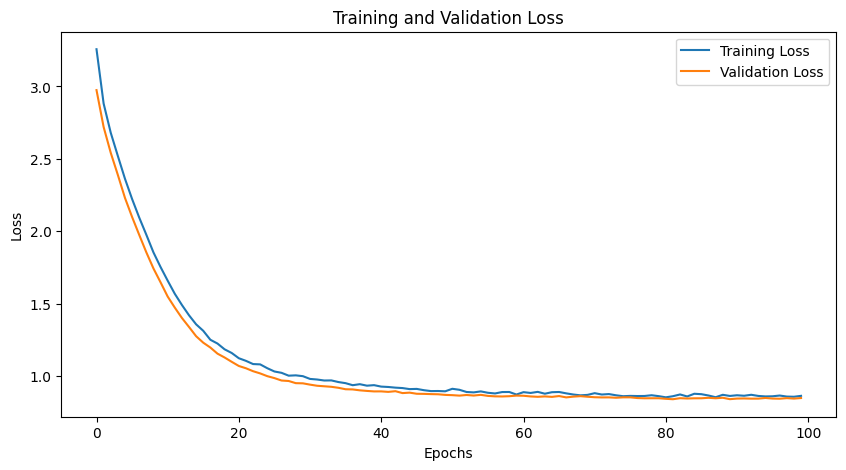

In [7]:
# Sample data and hyperparameters
#names = ["Alice", "Bobby", "Charl", "Diana"]
#dataset = NamesDataset(names)
#data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

batch_size=128
dataset = NamesDataset(names)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False,collate_fn=collate_fn)

# Model parameters
input_size = len(dataset.characters)+1
hidden_size = 200
#vocab_size = len(char_to_index)
output_size = input_size
num_layers = 4
embedding_dim = 15

model = RNNModel(input_size,embedding_dim, input_size,hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
train_losses, val_losses = train(model,train_loader, val_loader, criterion, optimizer, num_epochs=100)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
def generate(model, start_str='*', iterations=20,gender=0):
    new_names = []
    for _ in range(iterations):
        model.eval()
        inputs = torch.tensor([dataset.char_to_idx[start_str]], dtype=torch.long).unsqueeze(0)
        hidden = model.init_hidden(1)
        output_name = ''
    
        while(True):
            output, hidden = model(inputs,torch.tensor([gender]), hidden,torch.tensor([1]))
            probabilities = torch.softmax(output[0, -1], dim=0)
            char_idx = torch.multinomial(probabilities, 1).item()
            if dataset.idx_to_char[char_idx] == '.':
                break
            output_name += dataset.idx_to_char[char_idx]
            inputs = torch.tensor([[char_idx]], dtype=torch.long)
        if output_name not in names:
            new_names.append(output_name)   
    return new_names

In [12]:
generate(model,'.',30)

['நம்பணு',
 'கலையரசன்',
 'செல்லி',
 'வச்ளல்',
 'இசையொளி',
 'தமிழ்க்குயசன்',
 'இலக்கடுங்கரசு',
 'நாலேலன்',
 'தமிழ்ம்ருக்கதிர்',
 'முத்தாப்பருவேல்',
 'சிவார்',
 'குவந்தாயலன்',
 'கலைச்செல்வன்',
 'ப்ரீயமணி',
 'முத்துக்கனலன்',
 'பால்மணி',
 'யிசு',
 'ஆன்பரசன்',
 'தேனாணன்',
 'தமிழ்வழுதி',
 'பக்பொயன்',
 'முகுக்கோன்',
 'கோபாகன்',
 'கலை',
 'சாவன்',
 'குணர்கோ',
 'மாணிக்கோ',
 'செல்வகாராயியப்பன்',
 'குமரவேளன்',
 'கலைமாறன்']

In [10]:
len(names)

4301